In [344]:
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cluster, metrics, datasets

In [345]:
#d = pd.read_csv("data/past_seasons_totals.csv", encoding="utf-8")
pd.set_option('display.max_columns', None)
d=pd.read_csv("data/tot_adv_shooting.csv",encoding="utf-8")

modern_data = d.loc[(d["Year"]>1996) & (d["G"]>27) & (d["MP"]>500) & (pd.notnull(d["PPS_00-02 At Rim"]))]
modern_data = modern_data.replace({"Pos": {"PG":"G", "SG":"G","PG-SG":"G","SG-PG":"G","SG-SF":"G","SF-SG":"F","SF":"F","SF-PF":"F","PF":"F","PF-SF":"F","SG-PF":"F","PG-SF":"F","C-PF":"C","PF-C":"C","C-SF":"C"}})
modern_data

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,formatname,playername,PPS_00-02 At Rim,PPS_03-08 Near Rim,PPS_09-12 Short Range,PPS_13-17 Mid Range,PPS_18-23 Long Jumper,PPS_24-27 Three,PPS_28-34 Deep,PPS_35-46 Near Half,PPS_47-94 Backcourt,Points_00-02 At Rim,Points_03-08 Near Rim,Points_09-12 Short Range,Points_13-17 Mid Range,Points_18-23 Long Jumper,Points_24-27 Three,Points_28-34 Deep,Points_35-46 Near Half,Points_47-94 Backcourt
10728,1997.0,Mahmoud Abdul-Rauf,G,27.0,SAC,75.0,2131.0,13.2,0.524,0.266,0.147,0.9,5.9,3.3,15.8,1.4,0.2,10.8,23.2,2.0,0.7,2.7,0.060,-0.2,-3.4,-3.5,-0.8,411.0,924.0,0.445,94.0,246.0,0.382,317.0,678.0,0.468,0.496,115.0,136.0,0.846,16.0,106.0,122.0,189.0,56.0,6.0,119.0,174.0,1031.0,MahmoudAbdulRauf,Mahmoud Abdul-Rauf,0.967742,0.666667,1.098039,0.898678,0.890220,1.067797,1.000000,0.0,0.0,60.0,12.0,56.0,204.0,446.0,63.0,3.0,0.0,0.0
10729,1997.0,Shareef Abdur-Rahim,F,20.0,VAN,80.0,2802.0,17.4,0.518,0.022,0.428,8.8,14.2,11.5,12.1,1.5,2.2,13.5,27.6,1.7,1.2,2.9,0.049,-0.8,-1.2,-2.0,0.0,550.0,1214.0,0.453,7.0,27.0,0.259,543.0,1187.0,0.457,0.456,387.0,519.0,0.746,216.0,339.0,555.0,175.0,79.0,79.0,225.0,199.0,1494.0,ShareefAbdurRahim,Shareef Abdur-Rahim,1.054945,0.848485,0.746032,0.623377,0.793388,0.428571,0.000000,0.0,0.0,672.0,140.0,94.0,96.0,96.0,3.0,0.0,0.0,0.0
10731,1997.0,Cory Alexander,G,23.0,SAS,80.0,1454.0,14.3,0.528,0.514,0.263,2.3,8.0,5.1,30.0,3.1,0.9,21.1,22.2,0.5,0.6,1.1,0.035,0.8,-2.1,-1.3,0.2,194.0,490.0,0.396,94.0,252.0,0.373,100.0,238.0,0.420,0.492,95.0,129.0,0.736,29.0,94.0,123.0,254.0,82.0,16.0,146.0,148.0,577.0,CoryAlexander,Cory Alexander,0.836364,1.000000,0.933333,0.558140,0.784483,1.260870,0.000000,0.0,0.0,92.0,18.0,14.0,24.0,182.0,87.0,0.0,0.0,0.0
10732,1997.0,Jerome Allen,G,24.0,TOT,76.0,943.0,8.7,0.451,0.421,0.326,3.1,9.0,6.1,25.3,1.8,0.3,21.4,15.6,-0.3,0.8,0.4,0.021,-2.3,-1.1,-3.5,-0.3,78.0,221.0,0.353,30.0,93.0,0.323,48.0,128.0,0.375,0.421,42.0,72.0,0.583,25.0,73.0,98.0,152.0,31.0,4.0,69.0,84.0,228.0,JeromeAllen,Jerome Allen,0.897436,0.444444,0.857143,0.727273,0.692308,0.521739,0.000000,0.0,0.0,70.0,8.0,6.0,8.0,54.0,12.0,0.0,0.0,0.0
10733,1997.0,Ray Allen,G,21.0,MIL,82.0,2532.0,14.6,0.541,0.328,0.274,4.7,11.0,7.9,13.9,1.6,0.3,12.8,21.4,3.3,1.5,4.9,0.092,1.6,-1.2,0.3,1.5,390.0,908.0,0.430,117.0,298.0,0.393,273.0,610.0,0.448,0.494,205.0,249.0,0.823,97.0,229.0,326.0,210.0,75.0,10.0,149.0,218.0,1102.0,RayAllen,Ray Allen,0.937238,1.000000,0.813953,0.840237,0.871287,1.066667,0.000000,0.0,1.0,224.0,70.0,70.0,142.0,176.0,144.0,0.0,0.0,3.0
10736,1997.0,Greg Anderson,C,32.0,SAS,82.0,1659.0,11.4,0.531,0.004,0.355,11.0,21.8,16.2,3.2,2.1,3.2,19.4,10.5,0.7,1.5,2.2,0.064,-3.1,1.4,-1.6,0.2,130.0,262.0,0.496,0.0,1.0,0.000,130.0,261.0,0.498,0.496,62.0,93.0,0.667,157.0,291.0,448.0,34.0,63.0,67.0,73.0,225.0,322.0,GregAnderson,Greg Anderson,1.029787,0.800000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,242.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
10737,1997.0,Kenny Anderson,G,26.0,POR,82.0,3081.0,19.5,0.540,0.322,0.383,3.6,10.2,7.0,31.7,2.8,0.4,12.7,22.2,8.0,4.4,12.4,0.193,4.3,0.8,5.0,5.5,485.0,1137.0,0.427,132.0,366.0,0.361,353.0,771.0,0.458,0.485,334.0,435.0,0.768,91.0,272.0,363.0,584.0,162.0,15.0,193.0,222.0,1436.0,KennyAnderson,Kenny Anderson,1.034483,0.658537,0.600000,0.793388,0.804598,0.907895,1.000000,0.0,0.0,450.0,54.0,42.0,96.0,280.0,69.0,3.0,0.0,0.0
10738,1997.0,Nick Anderson,G,29.0,ORL,63.0,2163.0,13.8,0.494,0.559,0.130,3.5,13.2,8.2,14.5,3.0,1.1,10.1,18.2,1.3,2.9,4.2,0.093,1.2,1.4,2.6,2.5,288.0,725.0,0.397,143.0,405.0,0.353,145.0,320.0,0.453,0.496,38.0,94.0,0.404,66.0,238.0,304.0,182.0,120.0,32.0,86.0,160.0,757.0,NickAnderson,Nick Anderson,1.150000,0.811594,0.549020,0.755556,0.772334,0.866667,0.000000,0.0,0.0,138.0,56.0,28.0,34.0,268.0,78.0,0.0,0.0,0.0
10739,1997.0,Shandon Anderson,G,23.0,UTA,65.0,1066.0,10.4,0.534,0.148,0.311,6.5,14.

In [346]:
X = modern_data[["PPS_00-02 At Rim","PPS_03-08 Near Rim","PPS_09-12 Short Range","PPS_13-17 Mid Range","PPS_18-23 Long Jumper","PPS_24-27 Three","PPS_28-34 Deep","PPS_35-46 Near Half","PPS_47-94 Backcourt"]]
#[["3PAr", "FTr", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "PPS_00-02 At Rim","PPS_03-08 Near Rim","PPS_09-12 Short Range","PPS_13-17 Mid Range","PPS_18-23 Long Jumper","PPS_24-27 Three","PPS_28-34 Deep","PPS_35-46 Near Half","PPS_47-94 Backcourt","Points_00-02 At Rim","Points_03-08 Near Rim","Points_09-12 Short Range","Points_13-17 Mid Range","Points_18-23 Long Jumper","Points_24-27 Three","Points_28-34 Deep","Points_35-46 Near Half","Points_47-94 Backcourt"]]

    #'3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',            
y = modern_data["Pos"]

In [347]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [348]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.3329007214848214


In [349]:
LDA = LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage="auto")
LDA_reduced_df = LDA.fit(X_scaled,y).transform(X_scaled)
LDA.score(X_scaled,y)

0.5906276150627615

best silhouette score: 0.35207747608316825


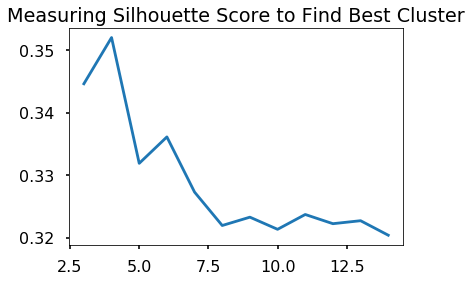

In [350]:
def kmeans(reduced_data, n_clusters):
    """
    performs kmeans clustering and returns labels, centroids, inertia, and silhouette score
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    kmeans = kmeans.fit(reduced_data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    sil_score = metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary

def find_best_cluster(data,a,b):
    """
    plots and finds the best silhouette score for range(a,b)
    """
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    print("best silhouette score:", np.max(scores))
find_best_cluster(LDA_reduced_df,3,15)

In [351]:
kmeans = kmeans(LDA_reduced_df, 8)

In [352]:
modern_data['Cluster'] = kmeans['labels']
y = kmeans['labels']
df = pd.DataFrame({'X1':LDA_reduced_df[:,0],'X2':LDA_reduced_df[:,1]})

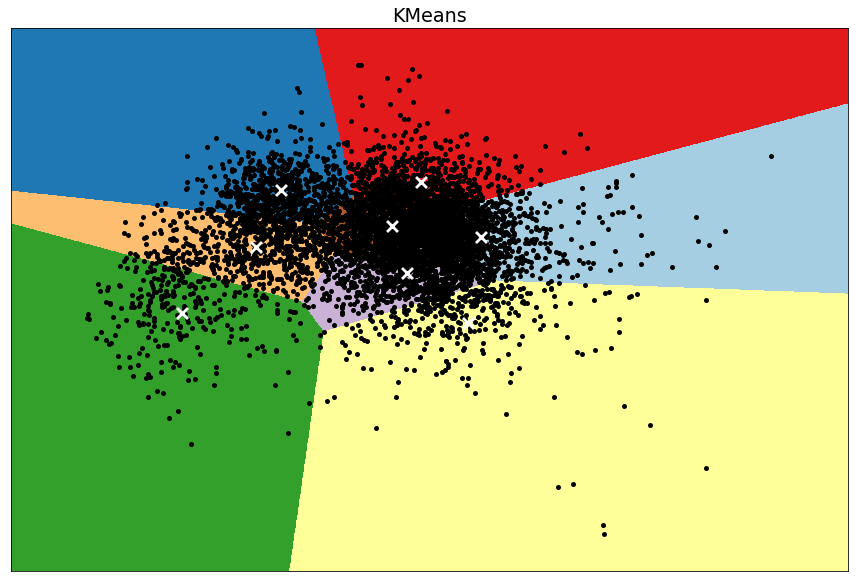

In [353]:
def plot_kmeans_cluster(reduced_data, k_clusters, plot_title):
    kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=20)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .005     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15,10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=120, linewidths=2,
            color='w', zorder=10)
    plt.title(plot_title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

plot_kmeans_cluster(LDA_reduced_df, k_clusters=8, plot_title="""KMeans""")

In [354]:
def feature_importance(cluster_data, league_data):
    """
    takes reduced data,
    performs Principal Component Analysis,
    returns feature importance dataframe
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(cluster_data.columns, pca.components_[0], np.mean(cluster_data), np.mean(league_data)),
        columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False).head(10)

    return features

In [359]:
i = 2
mask = (modern_data['Cluster'] == i)

cluster_data = modern_data[mask][["3PAr", "FTr", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "PPS_00-02 At Rim","PPS_03-08 Near Rim","PPS_09-12 Short Range","PPS_13-17 Mid Range","PPS_18-23 Long Jumper","PPS_24-27 Three","PPS_28-34 Deep","PPS_35-46 Near Half","PPS_47-94 Backcourt","Points_00-02 At Rim","Points_03-08 Near Rim","Points_09-12 Short Range","Points_13-17 Mid Range","Points_18-23 Long Jumper","Points_24-27 Three","Points_28-34 Deep","Points_35-46 Near Half","Points_47-94 Backcourt"]]
league_data = modern_data[["3PAr", "FTr", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "PPS_00-02 At Rim","PPS_03-08 Near Rim","PPS_09-12 Short Range","PPS_13-17 Mid Range","PPS_18-23 Long Jumper","PPS_24-27 Three","PPS_28-34 Deep","PPS_35-46 Near Half","PPS_47-94 Backcourt","Points_00-02 At Rim","Points_03-08 Near Rim","Points_09-12 Short Range","Points_13-17 Mid Range","Points_18-23 Long Jumper","Points_24-27 Three","Points_28-34 Deep","Points_35-46 Near Half","Points_47-94 Backcourt"]]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

pca = PCA(n_components=2)
PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

npmc = np.mean(cluster_data)
npml = np.mean(league_data)

features = pd.DataFrame(list(zip(cluster_data.columns, pca.components_[0], npmc, npml)), columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False)#.head(10)
features["%diff"] = (features["Cluster Average"]-features["League Average"])/features["League Average"] *100

features["level"] = np.where((features["%diff"] < -.7), "Bad",
                             np.where((features["%diff"] < -.2), "Subpar", 
                             np.where((features["%diff"] < .2), "Neutral", 
                             np.where((features["%diff"] < .7), "Above par", 
                             "Great"
                            ))))
features

,Feature,Importance,Cluster Average,League Average,%diff,level
17,Points_00-02 At Rim,0.388742,188.818623,219.453389,-13.959578,Bad
18,Points_03-08 Near Rim,0.376721,52.593598,62.786276,-16.233926,Bad
19,Points_09-12 Short Range,0.373408,35.615907,31.416234,13.367842,Great
7,USG%,0.354003,20.733366,19.350711,7.145238,Great
20,Points_13-17 Mid Range,0.353899,86.607177,68.347782,26.715417,Great
1,FTr,0.268263,0.250376,0.299416,-16.378551,Bad
2,TRB%,0.172712,7.616295,10.194494,-25.290112,Bad
21,Points_18-23 Long Jumper,0.161762,134.708050,84.988452,58.501593,Great
5,BLK%,0.147141,0.907662,1.646845,-44.884773,Bad
24,Points_35-46 Near Half,0.120997,0.407371,0.161172,152.756450,Great


In [360]:
modern_data.to_csv("test.csv")

In [361]:
modern_data.loc[(modern_data["Cluster"]==i) & (modern_data["Year"] > 1996)]

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,formatname,playername,PPS_00-02 At Rim,PPS_03-08 Near Rim,PPS_09-12 Short Range,PPS_13-17 Mid Range,PPS_18-23 Long Jumper,PPS_24-27 Three,PPS_28-34 Deep,PPS_35-46 Near Half,PPS_47-94 Backcourt,Points_00-02 At Rim,Points_03-08 Near Rim,Points_09-12 Short Range,Points_13-17 Mid Range,Points_18-23 Long Jumper,Points_24-27 Three,Points_28-34 Deep,Points_35-46 Near Half,Points_47-94 Backcourt,Cluster
10728,1997.0,Mahmoud Abdul-Rauf,G,27.0,SAC,75.0,2131.0,13.2,0.524,0.266,0.147,0.9,5.9,3.3,15.8,1.4,0.2,10.8,23.2,2.0,0.7,2.7,0.060,-0.2,-3.4,-3.5,-0.8,411.0,924.0,0.445,94.0,246.0,0.382,317.0,678.0,0.468,0.496,115.0,136.0,0.846,16.0,106.0,122.0,189.0,56.0,6.0,119.0,174.0,1031.0,MahmoudAbdulRauf,Mahmoud Abdul-Rauf,0.967742,0.666667,1.098039,0.898678,0.890220,1.067797,1.000000,0.000000,0.0,60.0,12.0,56.0,204.0,446.0,63.0,3.0,0.0,0.0,2
10731,1997.0,Cory Alexander,G,23.0,SAS,80.0,1454.0,14.3,0.528,0.514,0.263,2.3,8.0,5.1,30.0,3.1,0.9,21.1,22.2,0.5,0.6,1.1,0.035,0.8,-2.1,-1.3,0.2,194.0,490.0,0.396,94.0,252.0,0.373,100.0,238.0,0.420,0.492,95.0,129.0,0.736,29.0,94.0,123.0,254.0,82.0,16.0,146.0,148.0,577.0,CoryAlexander,Cory Alexander,0.836364,1.000000,0.933333,0.558140,0.784483,1.260870,0.000000,0.000000,0.0,92.0,18.0,14.0,24.0,182.0,87.0,0.0,0.0,0.0,2
10733,1997.0,Ray Allen,G,21.0,MIL,82.0,2532.0,14.6,0.541,0.328,0.274,4.7,11.0,7.9,13.9,1.6,0.3,12.8,21.4,3.3,1.5,4.9,0.092,1.6,-1.2,0.3,1.5,390.0,908.0,0.430,117.0,298.0,0.393,273.0,610.0,0.448,0.494,205.0,249.0,0.823,97.0,229.0,326.0,210.0,75.0,10.0,149.0,218.0,1102.0,RayAllen,Ray Allen,0.937238,1.000000,0.813953,0.840237,0.871287,1.066667,0.000000,0.000000,1.0,224.0,70.0,70.0,142.0,176.0,144.0,0.0,0.0,3.0,2
10751,1997.0,Brent Barry,G,25.0,LAC,59.0,1094.0,15.0,0.526,0.456,0.245,3.1,8.9,5.9,23.1,2.5,1.1,15.3,20.3,1.2,0.9,2.1,0.090,1.2,-1.1,0.0,0.6,155.0,379.0,0.409,56.0,173.0,0.324,99.0,206.0,0.481,0.483,76.0,93.0,0.817,30.0,80.0,110.0,154.0,51.0,15.0,76.0,88.0,442.0,BrentBarry,Brent Barry,1.022727,0.960000,0.631579,0.930233,0.785714,0.818182,1.500000,0.000000,0.0,90.0,24.0,12.0,40.0,110.0,45.0,6.0,0.0,0.0,2
10752,1997.0,Jon Barry,G,27.0,ATL,58.0,965.0,13.2,0.535,0.504,0.187,3.3,8.8,6.1,19.7,3.2,0.2,18.1,15.9,0.9,1.5,2.4,0.118,-0.2,0.4,0.2,0.5,100.0,246.0,0.407,48.0,124.0,0.387,52.0,122.0,0.426,0.504,37.0,46.0,0.804,26.0,73.0,99.0,115.0,55.0,3.0,59.0,56.0,285.0,JonBarry,Jon Barry,0.816327,0.571429,1.076923,0.709677,0.930693,0.866667,0.000000,0.000000,0.0,40.0,4.0,14.0,22.0,94.0,39.0,0.0,0.0,0.0,2
10758,1997.0,Muggsy Bogues,G,32.0,CHH,65.0,1880.0,15.7,0.554,0.325,0.144,1.7,7.2,4.5,38.6,2.4,0.1,18.6,14.5,3.9,1.1,5.0,0.127,1.3,-2.7,-1.3,0.3,204.0,443.0,0.460,60.0,144.0,0.417,144.0,299.0,0.482,0.528,54.0,64.0,0.844,25.0,116.0,141.0,469.0,82.0,2.0,108.0,114.0,522.0,MuggsyBogues,Muggsy Bogues,0.596774,0.615385,1.058824,1.092784,1.172840,0.642857,0.000000,0.000000,0.0,74.0,8.0,18.0,106.0,190.0,18.0,0.0,0.0,0.0,2
10765,1997.0,Terrell Brandon,G,26.0,CLE,78.0,2868.0,21.5,0.526,0.206,0.226,2.1,11.7,6.8,35.6,2.8,0.9,11.0,28.3,6.2,4.7,10.8,0.181,3.8,0.8,4.6,4.8,575.0,1313.0,0.438,101.0,271.0,0.373,474.0,1042.0,0.455,0.476,268.0,297.0,0.902,48.0,253.0,301.0,490.0,138.0,30.0,178.0,177.0,1519.0,TerrellBrandon,Terrell Brandon,1.111111,0.816901,0.644444,0.860465,0.859729,1.114286,0.000000,1.500000,0.0,230.0,58.0,58.0,370.0,380.0,78.0,0.0,3.0,0.0,2
10789,1997.0,Sam Cassell,G,27.0,TOT,61.0,1714.0,18.4,0.541,0.295,0.321,3.0,9.1,6.0,31.8,2.3,0.8,15.8,27.3,2.7,1.1,3.9,0.108,2.8,-1.6,1.2,1.4,337.0,783.0,0.430,81.0,231.0,0.351,256.0,552.0,0.464,0.482,212.0,251.0,0.845,47.0,135.0,182.0,305.0,77.0,19.0,168.0,200.0,967.0,SamCassell,Sam Cassell,1.162562,0.579710,0.794872,0.846154,0.751220,1.119403,0.000000,0.000000,0.0,236.0,40.0,62.0,132.0,154.0,75.0,0.0,0.0,0.0,2
10797,1997.0,Chris Childs,G,29.0,NYK,65.0,2076.0,11.2,0.

In [362]:
modern_data.loc[(modern_data["formatname"]=="KembaWalker")]

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,formatname,playername,PPS_00-02 At Rim,PPS_03-08 Near Rim,PPS_09-12 Short Range,PPS_13-17 Mid Range,PPS_18-23 Long Jumper,PPS_24-27 Three,PPS_28-34 Deep,PPS_35-46 Near Half,PPS_47-94 Backcourt,Points_00-02 At Rim,Points_03-08 Near Rim,Points_09-12 Short Range,Points_13-17 Mid Range,Points_18-23 Long Jumper,Points_24-27 Three,Points_28-34 Deep,Points_35-46 Near Half,Points_47-94 Backcourt,Cluster
17848,2012.0,Kemba Walker,G,21.0,CHA,66.0,1792.0,14.9,0.464,0.295,0.278,1.9,13.5,7.5,30.2,1.8,0.8,12.1,25.2,-0.2,0.5,0.3,0.009,0.6,-1.8,-1.2,0.3,281.0,767.0,0.366,69.0,226.0,0.305,212.0,541.0,0.392,0.411,168.0,213.0,0.789,30.0,204.0,234.0,289.0,60.0,20.0,119.0,79.0,799.0,KembaWalker,Kemba Walker,1.000000,0.622951,0.857143,0.652482,0.714286,0.949749,0.000000,0.0,0.00,166.0,38.0,30.0,92.0,110.0,189.0,0.0,0.0,0.0,0
18319,2013.0,Kemba Walker,G,22.0,CHA,82.0,2859.0,18.8,0.517,0.267,0.298,2.3,9.2,5.7,31.2,2.9,0.9,12.4,25.6,3.7,1.1,4.8,0.080,3.2,-1.7,1.5,2.5,526.0,1244.0,0.423,107.0,332.0,0.322,419.0,912.0,0.459,0.466,296.0,371.0,0.798,60.0,223.0,283.0,471.0,160.0,31.0,200.0,153.0,1455.0,KembaWalker,Kemba Walker,1.095745,0.615385,0.641975,0.981481,0.721088,1.014085,0.562500,0.0,0.00,412.0,72.0,52.0,212.0,106.0,288.0,9.0,0.0,0.0,2
18802,2014.0,Kemba Walker,G,23.0,CHA,73.0,2614.0,16.8,0.499,0.286,0.295,1.7,11.6,6.6,29.7,1.7,1.0,11.6,25.8,1.8,3.3,5.1,0.093,1.6,0.2,1.7,2.4,449.0,1143.0,0.393,109.0,327.0,0.333,340.0,816.0,0.417,0.441,282.0,337.0,0.837,39.0,267.0,306.0,447.0,86.0,32.0,169.0,128.0,1289.0,KembaWalker,Kemba Walker,1.027668,0.698795,0.735294,0.783582,0.706587,1.042553,0.818182,0.0,0.00,260.0,58.0,50.0,210.0,118.0,294.0,9.0,0.0,0.0,0
19293,2015.0,Kemba Walker,G,24.0,CHO,62.0,2119.0,17.6,0.486,0.285,0.288,1.8,9.9,5.7,27.1,2.2,1.2,8.3,25.9,1.8,2.6,4.5,0.101,2.2,0.1,2.2,2.3,378.0,981.0,0.385,85.0,280.0,0.304,293.0,701.0,0.418,0.429,234.0,283.0,0.827,35.0,185.0,220.0,318.0,89.0,31.0,100.0,92.0,1075.0,KembaWalker,Kemba Walker,0.988142,0.787879,0.507042,0.727273,0.852459,0.995745,0.461538,0.0,0.00,250.0,78.0,36.0,128.0,104.0,234.0,6.0,0.0,0.0,0
19769,2016.0,Kemba Walker,G,25.0,CHO,81.0,2885.0,20.8,0.554,0.368,0.329,2.1,11.5,6.8,25.7,2.2,1.1,10.1,26.5,6.3,3.6,9.9,0.165,4.0,0.0,4.0,4.4,568.0,1331.0,0.427,182.0,490.0,0.371,386.0,841.0,0.459,0.495,371.0,438.0,0.847,56.0,301.0,357.0,421.0,126.0,39.0,171.0,111.0,1689.0,KembaWalker,Kemba Walker,1.198795,0.654545,0.835821,0.748466,0.733945,1.139151,0.500000,0.0,0.75,398.0,72.0,56.0,122.0,160.0,483.0,6.0,0.0,3.0,2
20251,2017.0,Kemba Walker,G,26.0,CHO,79.0,2739.0,21.3,0.569,0.415,0.248,1.8,10.6,6.2,29.1,1.6,0.7,9.5,29.2,5.9,2.2,8.1,0.142,5.3,-1.7,3.6,3.9,643.0,1449.0,0.444,240.0,602.0,0.399,403.0,847.0,0.476,0.527,304.0,359.0,0.847,45.0,263.0,308.0,435.0,85.0,22.0,168.0,119.0,1830.0,KembaWalker,Kemba Walker,1.097506,0.632911,0.792453,0.867925,0.794872,1.238636,0.600000,0.0,0.00,484.0,50.0,42.0,138.0,124.0,654.0,18.0,0.0,0.0,2
20783,2018.0,Kemba Walker\walkeke02,G,27.0,CHO,80.0,2736.0,20.6,0.572,0.441,0.308,1.2,8.7,4.9,27.4,1.6,0.7,10.4,27.4,6.5,2.0,8.5,0.150,5.1,-1.9,3.2,3.6,588.0,1363.0,0.431,231.0,601.0,0.384,357.0,762.0,0.469,0.516,363.0,420.0,0.864,31.0,216.0,247.0,444.0,91.0,24.0,179.0,98.0,1770.0,KembaWalker,Kemba Walker,1.149351,0.591837,0.857143,0.911392,0.760563,1.203390,0.656250,0.0,0.00,354.0,58.0,72.0,144.0,108.0,639.0,21.0,0.0,0.0,2
